In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Loading dataset

In [2]:
# Selecting columns of interest

columns = ["NU_IDADE", "SG_UF_RESIDENCIA", "TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA", 
           "IN_TREINEIRO", "NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "TP_LINGUA", 
           "NU_NOTA_REDACAO", "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009", "Q010", "Q011", 
           "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018", "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025"]

data = pd.read_csv("../dataset/raw_dataset.csv", sep = ";")
data = data[columns]
print(data.shape)
data.head()

(5095270, 40)


,NU_IDADE,SG_UF_RESIDENCIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,NU_NOTA_CN,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,21,PA,M,1,3,1,3,1,0,472.9,...,A,A,A,C,B,A,D,A,B,A
1,16,PA,F,1,3,3,0,1,1,358.9,...,A,A,A,B,B,A,B,A,A,A
2,18,PA,F,1,1,2,0,3,0,574.2,...,B,A,A,D,B,B,D,A,C,B
3,23,PA,M,0,3,2,0,2,0,NaN,...,A,A,A,C,A,A,D,A,A,A
4,23,PA,M,1,3,1,5,1,0,NaN,...,A,A,A,B,A,A,D,A,A,A


### Renaming Columns

In [3]:
data = data.rename(columns={"Q001": "Escolaridade_Pai", 
                            "Q002": "Escolaridade_Mae",
                            "Q003": "Ocupacao_Pai",
                            "Q004": "Ocupacao_Mae",
                            "Q005": "Pessoas_Residencia",
                            "Q006": "Renda_Mensal",
                            "Q007": "Empregada_Domestica",
                            "Q008": "Banheiros",
                            "Q009": "Quartos",
                            "Q010": "Carro",
                            "Q011": "Motocicleta",
                            "Q012": "Geladeira",
                            "Q013": "Freezer",
                            "Q014": "Lava_Roupa",
                            "Q015": "Seca_Roupa",
                            "Q016": "Microondas",
                            "Q017": "Lava_Louca",
                            "Q018": "Aspirador",
                            "Q019": "Televisao",
                            "Q020": "DVD",
                            "Q021": "TV_Assinatura",
                            "Q022": "Celular",
                            "Q023": "Telefone_Fixo",
                            "Q024": "Computador",
                            "Q025": "Internet",
                           })

### Treating NA values

In [4]:
def count_NA_values(df):
    flag = 0
    for col in df.columns:
        na_sum = df[col].isna().sum()
        if na_sum != 0:
            flag = 1
            print("NA values on column " + col + ": " + str(na_sum))
    if flag == 0:
        print("There isn't any NA value")
        
count_NA_values(data)

NA values on column NU_NOTA_CN: 1384837
NA values on column NU_NOTA_CH: 1172125
NA values on column NU_NOTA_LC: 1172125
NA values on column NU_NOTA_MT: 1384837
NA values on column NU_NOTA_REDACAO: 1172126


In [5]:
# NA values are probably due to absence. We will remove them.

data = data.dropna()
count_NA_values(data)
print(data.shape)

There isn't any NA value
(3702007, 40)


### Removing trainees

In [6]:
data = data[data["IN_TREINEIRO"] == 0]
data = data.drop("IN_TREINEIRO", 1) 
print(data.shape)

(3174308, 39)


### Checking target variable distribution

In [7]:
score_targets = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO"]
names = ["Ciências da Natureza", "Ciências Humanas", "Linguagens", "Matemática", "Redação"]

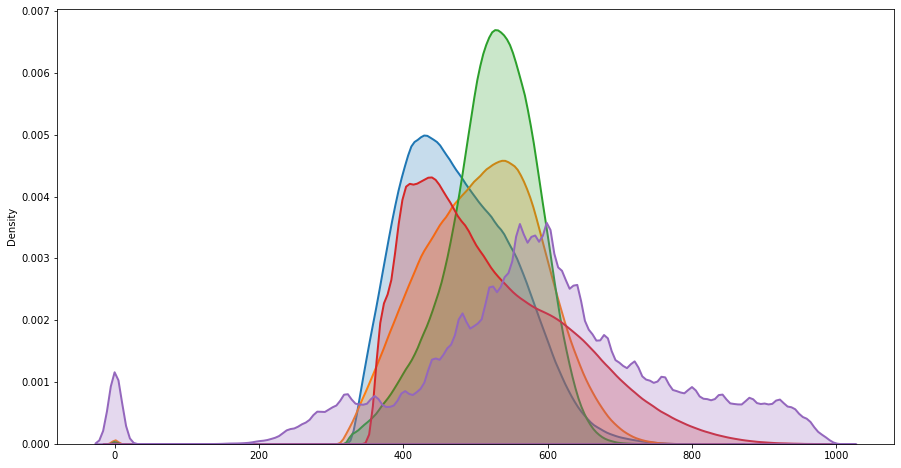

In [8]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(score_targets):
        sns.distplot(data[col], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2}, 
                      label = names[i])
plt.xlabel("")
plt.savefig("../pictures/Densidade_notas_por_disciplina.png")

### Creating new variable to establish mean score

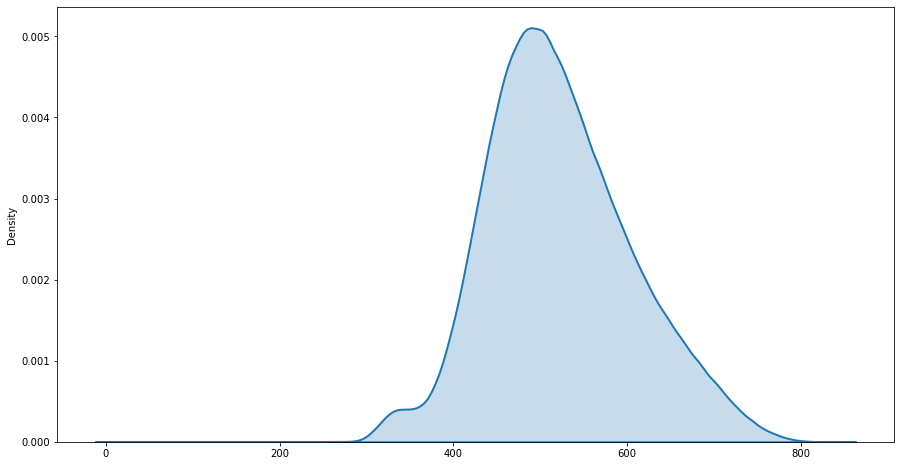

In [9]:
def calcula_media(data):
    media = (data["NU_NOTA_CN"]+data["NU_NOTA_CH"]+data["NU_NOTA_LC"]+data["NU_NOTA_REDACAO"]+data["NU_NOTA_MT"])/5
    return media

data["Media"] = data.apply(calcula_media, 1)
for col in score_targets:
    data = data.drop(col, 1)

plt.figure(figsize=(15, 8))
sns.distplot(data["Media"], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2})
plt.xlabel("")
plt.savefig("../pictures/Densidade_media.png")

### Removing under age 15

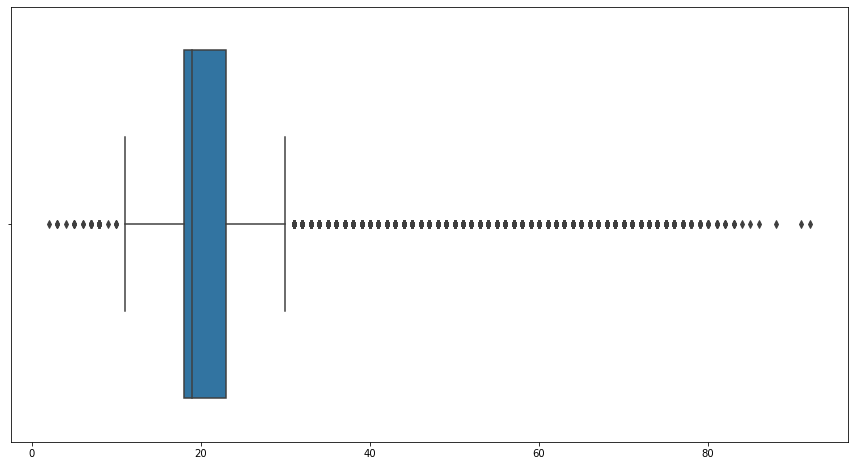

In [10]:
plt.figure(figsize=(15, 8))
sns.boxplot(x = data["NU_IDADE"])
plt.xlabel("")
plt.savefig("../pictures/Distribuicao_Idade.png")

In [11]:
data = data[data["NU_IDADE"]>15]

### Replacing the continuous target feature by discretized values
#### The scores will be converted into levels. If < 50% percentile: 1, else: 0

In [12]:
data["DESEMPENHO_BAIXO"] = pd.qcut(data["Media"], q = [0, 0.5, 1], labels = [0, 1])
data["DESEMPENHO_BAIXO"] = data["DESEMPENHO_BAIXO"].replace([0,1], [True, False])
data = data.drop("Media", 1)

### Exploring relations between level targets and some predictive features

#### Race / Color of skin

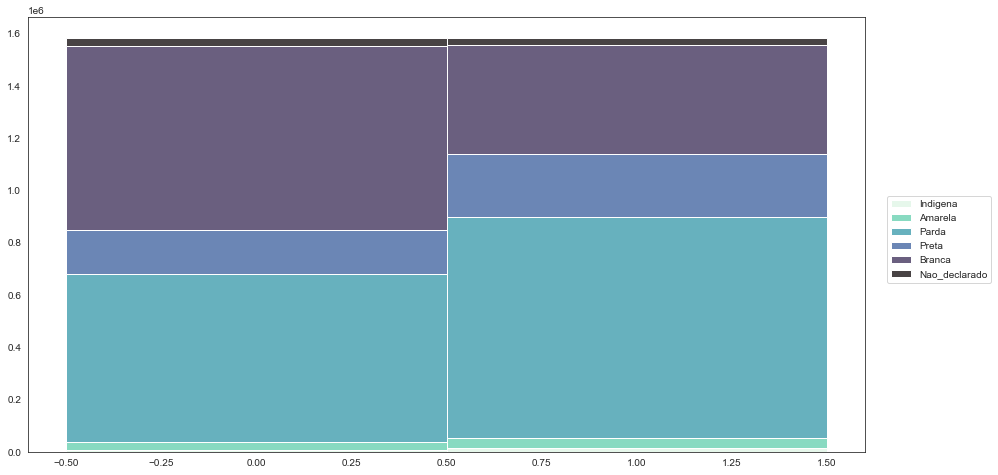

In [13]:
sns.set_style("white")

legend = ["Indigena", "Amarela", "Parda", "Preta", "Branca", "Nao_declarado"]

plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "TP_COR_RACA", binwidth = 1, discrete= True, multiple="stack", legend = True,
                    palette = "mako")
ax.legend(legend, bbox_to_anchor=(1.02, 0.6))
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_niveis_raca.png")

#### Father's education

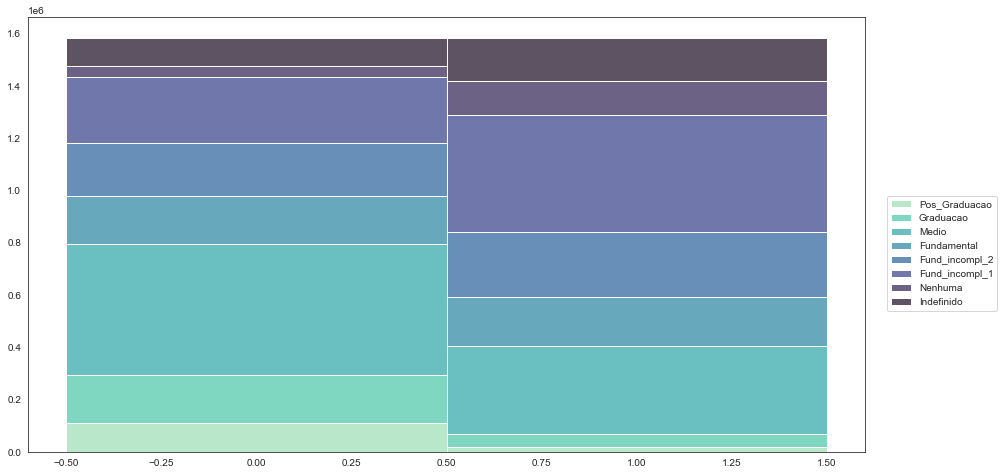

In [14]:
legend = ["Pos_Graduacao", "Graduacao", "Medio", "Fundamental", "Fund_incompl_2", "Fund_incompl_1", "Nenhuma", "Indefinido"]

plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "Escolaridade_Pai", binwidth=1, discrete= True, multiple="stack", 
                 hue_order= ["H", "A", "B", "C", "D", "E", "F", "G"], legend = True, palette = "mako")
ax.legend(legend, loc = 1)
ax.legend(legend, bbox_to_anchor=(1.02, 0.6))
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_escolaridade_pai.png")

#### Mother's education

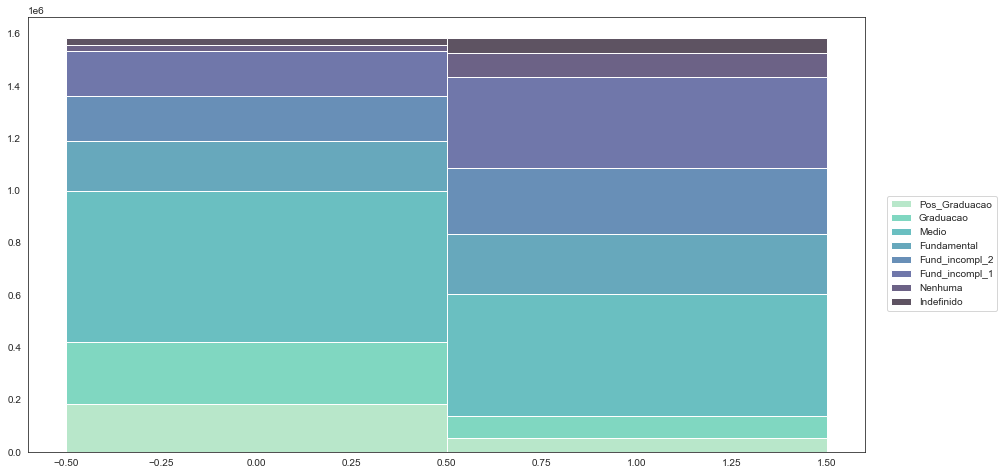

In [15]:
legend = ["Pos_Graduacao", "Graduacao", "Medio", "Fundamental", "Fund_incompl_2", "Fund_incompl_1", "Nenhuma", "Indefinido"]

plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "Escolaridade_Mae", binwidth=1, discrete= True, multiple="stack", 
                 hue_order= ["H", "A", "B", "C", "D", "E", "F", "G"], legend = True, palette = "mako")
ax.legend(legend, loc = 1)
ax.legend(legend, bbox_to_anchor=(1.02, 0.6))
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_escolaridade_mae.png")

#### Father's profession

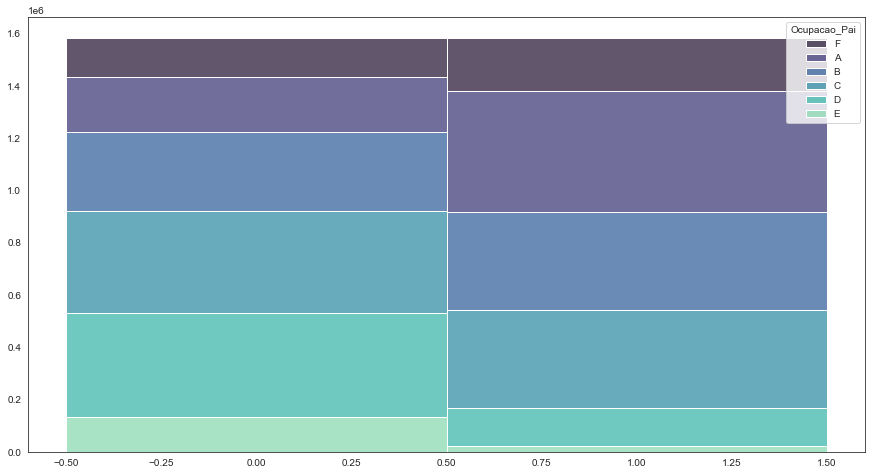

In [16]:
plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "Ocupacao_Pai", binwidth=1, discrete= True, multiple="stack", 
                 hue_order= ["F", "A", "B", "C", "D", "E"], legend = True, palette = "mako")
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_profissao_pai.png")

#### Mother's profession

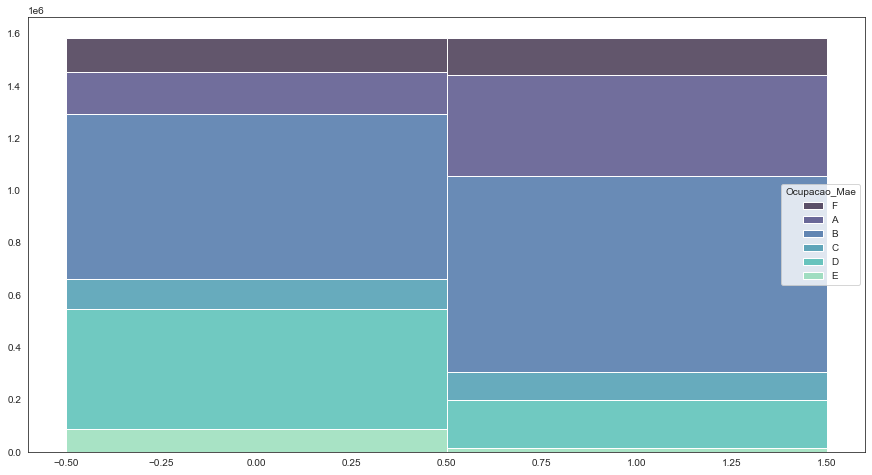

In [17]:
plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "Ocupacao_Mae", binwidth=1, discrete= True, multiple="stack", 
                 hue_order= ["F", "A", "B", "C", "D", "E"], legend = True, palette = "mako")
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_profissao_pai.png")

#### Count of Toilets

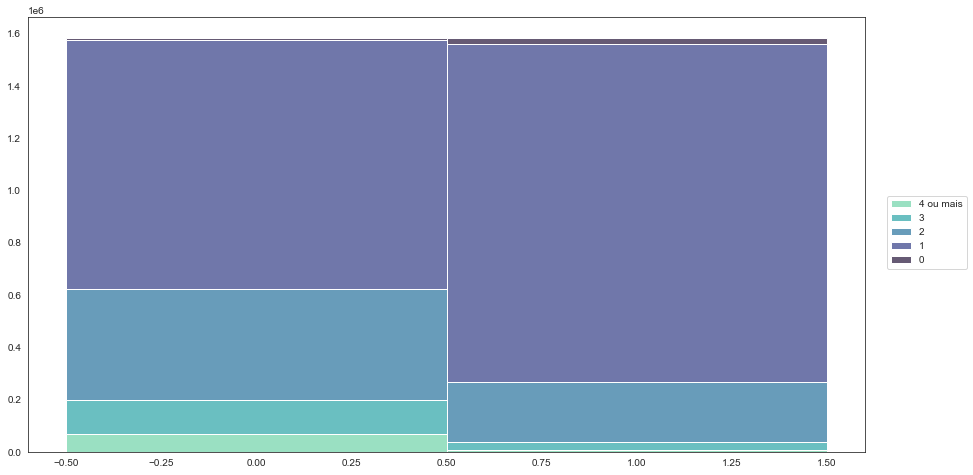

In [18]:
plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "Banheiros", binwidth=1, discrete= True, multiple="stack", 
                      hue_order= ["A", "B", "C", "D", "E"], palette = "mako") 
ax.legend(["4 ou mais", 3, 2, 1, 0],bbox_to_anchor=(1.02, 0.6))
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_niveis_banheiros.png")

#### By Sex

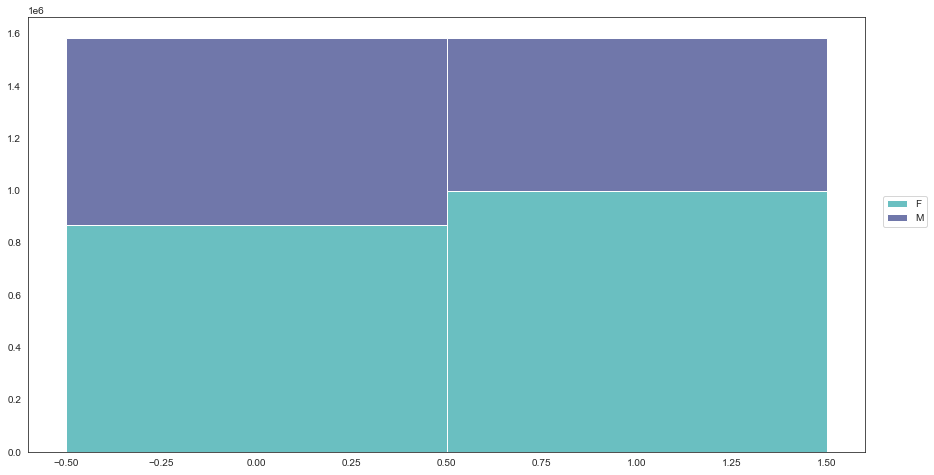

In [19]:
plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "TP_SEXO", binwidth=1, discrete= True, multiple="stack",
                 palette = "mako")
ax.legend(["F", "M"], bbox_to_anchor=(1.08, 0.6))
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_niveis_por_sexo.png")

#### Count of computers

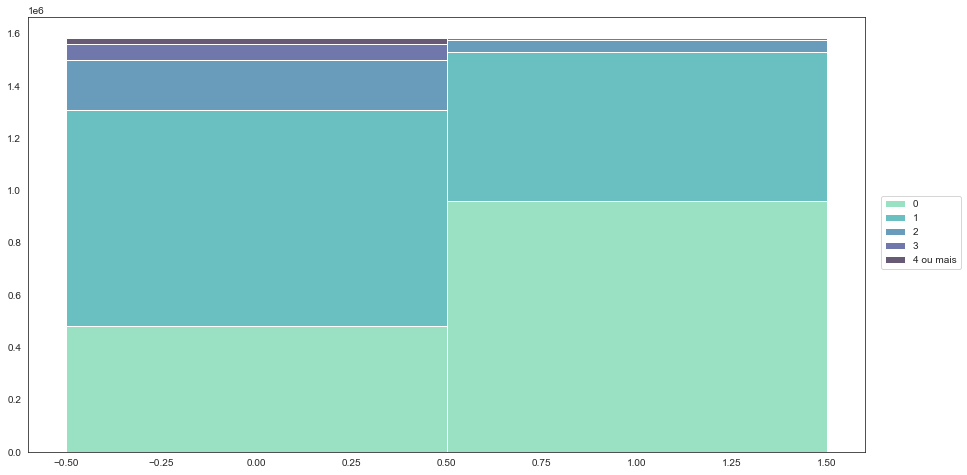

In [20]:
plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "Computador", binwidth=1, discrete= True, multiple="stack", 
                      hue_order = ["E", "D", "C", "B", "A"], palette = "mako")
ax.legend([0, 1, 2, 3, "4 ou mais"], bbox_to_anchor=(1.12, 0.6))
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_niveis_por_computadores.png")

#### Type of school

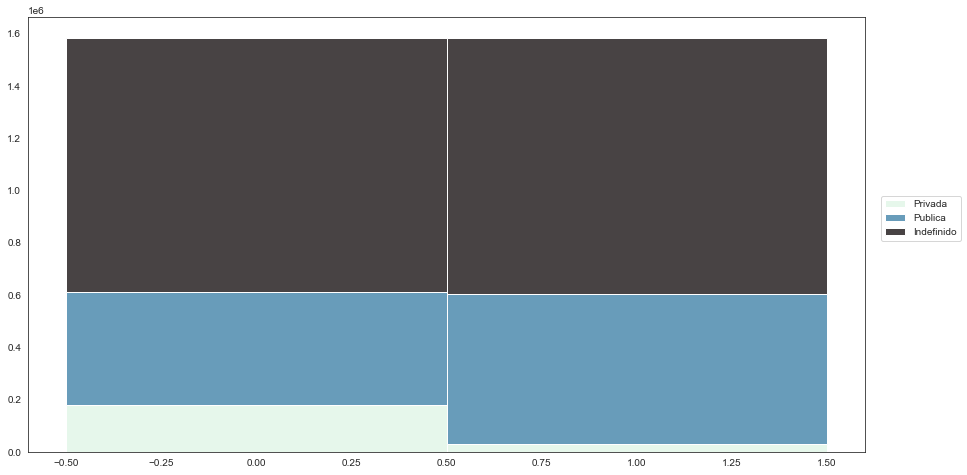

In [21]:
legend = ["Privada", "Publica", "Indefinido"]

plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "TP_ESCOLA", binwidth=1, discrete= True, multiple="stack",
                 palette = "mako")
ax.legend(legend, bbox_to_anchor=(1.12, 0.6))
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_niveis_por_escola.png")

#### Closes Dryer

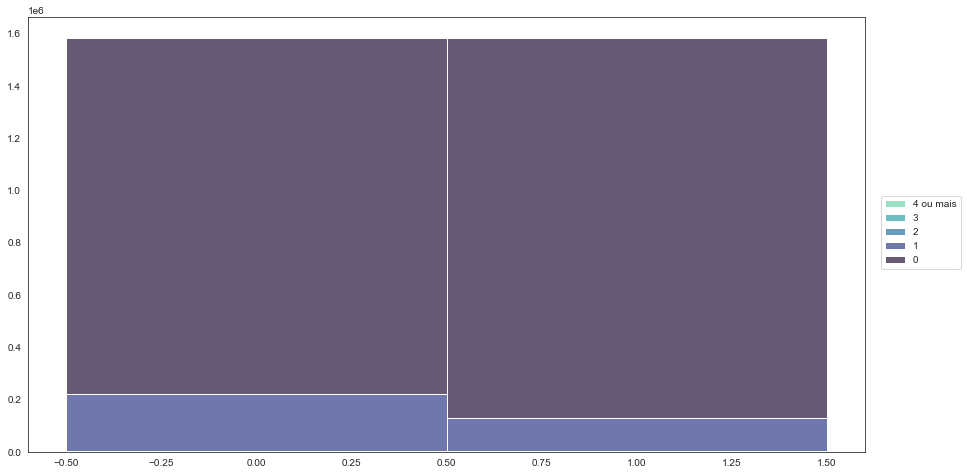

In [22]:
plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "Seca_Roupa", binwidth=1, discrete= True, multiple="stack",
                     hue_order = ["A", "B", "C", "D", "E"], palette = "mako")
ax.legend(["4 ou mais", 3, 2, 1, 0], bbox_to_anchor=(1.12, 0.6))
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_niveis_por_seca_roupas.png")

#### Wifi

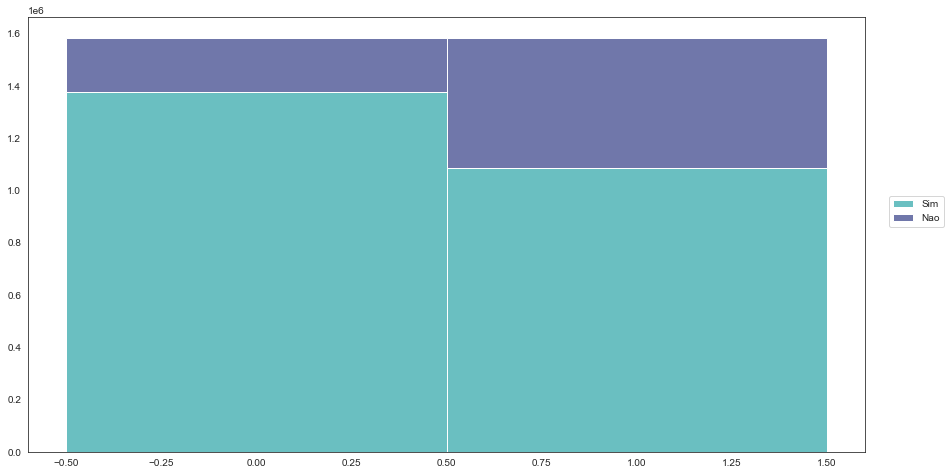

In [23]:
plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "Internet", binwidth=1, discrete= True, multiple="stack", 
                  palette = "mako", legend = True)
ax.legend(["Sim", "Nao"], bbox_to_anchor=(1.10, 0.6))
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_niveis_por_wifi.png")

#### Income

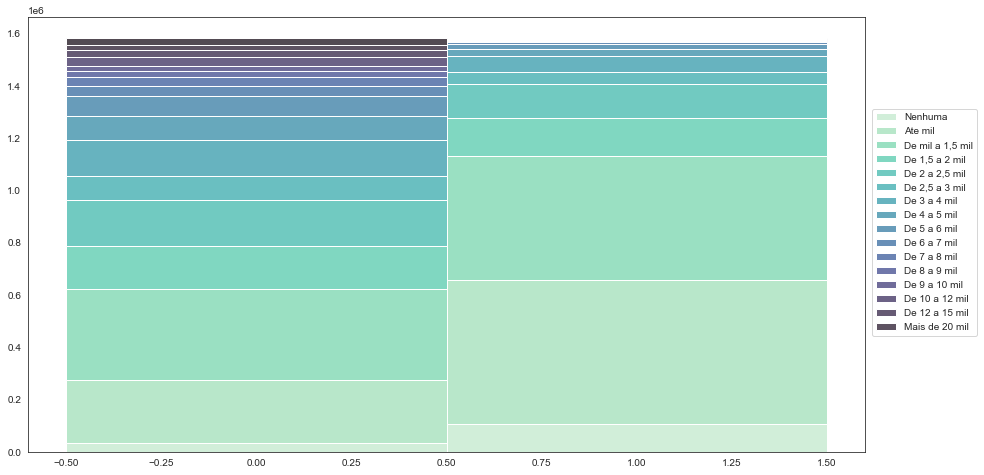

In [24]:
legend = ["Nenhuma", "Ate mil", "De mil a 1,5 mil", "De 1,5 a 2 mil", "De 2 a 2,5 mil", "De 2,5 a 3 mil", "De 3 a 4 mil",
          "De 4 a 5 mil", "De 5 a 6 mil", "De 6 a 7 mil", "De 7 a 8 mil", "De 8 a 9 mil", "De 9 a 10 mil", "De 10 a 12 mil",
          "De 12 a 15 mil", "Mais de 20 mil"]

plt.figure(figsize=(15, 8))
ax = sns.histplot(data, x = "DESEMPENHO_BAIXO", hue = "Renda_Mensal", binwidth=1, discrete= True, multiple="stack",
                     hue_order = ["Q", "P", "O", "N", "M", "L", "K", "J", "I", "H", "G", "F", "E", "D", "C", "B", "A"],
                     palette = "mako")
ax.legend(legend, bbox_to_anchor=(1.14, 0.8))
plt.xlabel("")
plt.ylabel("")
plt.savefig("../pictures/Distribuicao_niveis_por_renda.png")

### Saving dataset

In [25]:
data.to_csv("../dataset/dataset_1.csv", sep = ";")